In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from urllib.request import urlopen
import json
from credentials import *
from entsoe import EntsoePandasClient
from entsoe.mappings import lookup_area
from pycaret.time_series import *
import logging

mpl.rcParams['figure.dpi'] = 150
logging.disable(logging.CRITICAL)


### Loading Dataset

In [23]:
# Get energy data from ENTSO-E API
country_code = 'FR'
area = lookup_area(country_code)

client = EntsoePandasClient(api_key=get_token())
end = pd.Timestamp.now(tz=area.tz) # - pd.DateOffset(days=10)
start = end - pd.DateOffset(weeks = 2)
%time df_energy = client.query_generation(area, start=start,end=end, nett = True, psr_type=None)
df_energy.set_index(df_energy.index.tz_convert(None), inplace = True)
df_energy = df_energy.resample('H').mean()
df_energy.tail()

Wall time: 3.97 s


,Biomass,Fossil Gas,Fossil Hard coal,Fossil Oil,Hydro Pumped Storage,Hydro Run-of-river and poundage,Hydro Water Reservoir,Nuclear,Solar,Waste,Wind Onshore
2022-07-11 21:00:00,331.0,4473.0,24.0,294.0,1221.0,2894.0,1700.0,28077.0,0.0,178.0,3885.0
2022-07-11 22:00:00,331.0,4409.0,28.0,195.0,238.0,2736.0,1755.0,27714.0,0.0,172.0,3959.0
2022-07-11 23:00:00,331.0,4296.0,28.0,145.0,-588.0,2382.0,1489.0,27846.0,0.0,169.0,3718.0
2022-07-12 00:00:00,330.0,4517.0,29.0,145.0,-892.0,2258.0,874.0,27502.0,0.0,166.0,3510.0
2022-07-12 01:00:00,331.0,4558.0,29.0,145.0,-1408.0,2286.0,1136.0,27380.0,0.0,167.0,3230.0


In [26]:
# Download and save all country data
for code in country_codes:
    # Get energy data from ENTSO-E API
    area = lookup_area(code)
    client = EntsoePandasClient(api_key=get_token())
    end = pd.Timestamp.now(tz=area.tz) # - pd.DateOffset(days=10)
    start = end - pd.DateOffset(weeks = 2)
    try:
        df_energy = client.query_generation(area, start=start,end=end, nett = True,     psr_type=None)
    except:
        print('No data for {}'.format(code))
        continue
    df_energy.set_index(df_energy.index.tz_convert(None), inplace = True)
    df_energy = df_energy.resample('H').mean()
    path = 'country_data/{}.csv'.format(code)
    df_energy.to_csv(path, float_format = '%.2f')

No data for CY
No data for MT


### Forecasting with PyCaret

In [3]:
ts = setup(data = df_energy['Solar'], fh = 48,
           enforce_exogenous = False, fold = 3)
           

,Description,Value
0,session_id,5454
1,Target,Solar
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(335, 1)"
5,Transformed data shape,"(335, 1)"
6,Transformed train set shape,"(287, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [4]:
model = create_model('auto_arima', cross_validation = False, engine = 'statsforecast')

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,5.9785,3.6151,386.1725,597.1711,274597604779692.5938,1.0647,0.6606


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

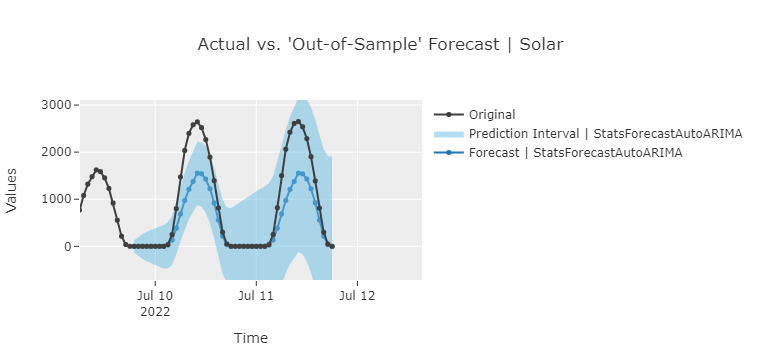

In [5]:
fig_kwargs = {'renderer': 'jupyterlab'}

plot_model(model, 'forecast', fig_kwargs = fig_kwargs)

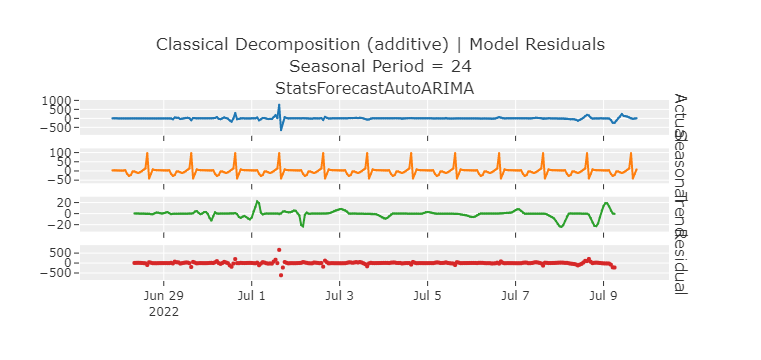

In [6]:
plot_model(model, 'decomp', fig_kwargs = fig_kwargs)